# MAPPING REAL DATA TO WOFOST INPUT/OUTPUT

In [1]:
import sys, os.path
import yaml
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ast import literal_eval
from IPython.display import display
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 250)

import pcse
from pcse.models import Wofost71_PP
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.fileinput import YAMLCropDataProvider
from pcse.fileinput import CABOFileReader
from pcse.engine import Engine

from progressbar import printProgressBar
import utils
import nass

Platform not recognized, using system temp directory for PCSE settings.
Platform not recognized, using system temp directory for PCSE settings.


Building PCSE demo database at: /var/folders/mn/2kcblfmx7mgf8t95n54qmg4w0000gn/T/.pcse/pcse.db ... OK


# WOFOST Inputs
#### Crop:	
    - TMNFTB    = 0.00,    0.00,     : red. factor of gross assim. rate
                  3.00,    1.00      : as function of low min. temp. [cel; -]
    - CO2 = 720.			 
    - CO2AMAXTB = 40., 0.00,         : multiplication factor for AMAX 
                 360.,  1.00,        : to account for an increasing CO2 concentration
                 720.,  1.35, 
                1000.,  1.50,
                2000.,  1.50
    - CO2EFFTB  = 40., 0.00,		 : multiplication factor for EFF 
                 360.,  1.00,		 : to account for an increasing CO2 concentration
                 720.,  1.11, 
                1000.,  1.11,
                2000.,  1.11
    - CO2TRATB  = 40., 0.00,		 : multiplication factor for maximum transpiration rate TRAMX
                 360.,  1.00,		 : to account for an increasing CO2 concentration
                 720.,  0.9, 
                1000.,  0.9,
                2000.,  0.9
    - CVL      =   0.685  : efficiency of conversion into leaves [kg kg-1]
    - CVO      =   0.709  : efficiency of conversion into storage org. [kg kg-1]
    - CVR      =   0.694  : efficiency of conversion into roots [kg kg-1]
    - CVS      =   0.662  : efficiency of conversion into stems [kg kg-1]

    - Q10      =   2.0    : rel. incr. in resp. rate per 10 Cel temp. incr. [-]
    - RML      =   0.0300 : rel. maint. resp. rate leaves [kg CH2O kg-1 d-1]
    - RMO      =   0.0100 : rel. maint. resp. rate stor.org. [kg CH2O kg-1 d-1]
    - RMR      =   0.0150 : rel. maint. resp. rate roots [kg CH2O kg-1 d-1]
    - RMS      =   0.0150 : rel. maint. resp. rate stems [kg CH2O kg-1 d-1]
    - RFSETB   =   0.00, 1.00,     : red. factor for senescence
                   2.00, 1.00      : as function of DVS [-; -]
and many more... 
    
#### Weather: 
    - NASAPowerWeatherDataProvider(latitude, longitude)

#### Soil:
    - SOLNAM   = 'EC4-fine'
    - SMTAB    =  vector  : vol. soil moisture content as function of pF [log (cm); cm3 cm-3]
    - SMW      =   0.300  :  soil moisture content at wilting point [cm3/cm3]
    - SMFCF    =   0.460  :  soil moisture content at field capacity [cm3/cm3]
    - SM0      =   0.570  :  soil moisture content at saturation [cm3/cm3]
    - CRAIRC   =   0.050  : critical soil air content for aeration [cm3/cm3]
    - CONTAB   =   vector : 10-log hydraulic conductivity : as function of pF [log (cm); log (cm/day)]
    - RDMSOL   =   120.   : soil maximum rootable depth
    - K0       =   10.789 : hydraulic conductivity of saturated soil [cm day-1]
    - SOPE     =   0.55   : maximum percolation rate root zone[cm day-1]
    - KSUB     =   0.37   : maximum percolation rate subsoil [cm day-1]
    - SPADS    =   0.050  :  1st topsoil seepage parameter deep seedbed
    - SPODS    =   0.025  :  2nd topsoil seepage parameter deep seedbed
    -  SPASS   =   0.100  :  1st topsoil seepage parameter shallow seedbed
    - SPOSS    =   0.040  :  2nd topsoil seepage parameter shallow seedbed
    - DEFLIM   =  -0.300  :  required moisture deficit deep seedbed

#### Site:
    - SMLIM        =  0.3   : Limiting amount of volumetric moisture in upper soil layer [-]
    - IFUNRN       =  0     : Rain infiltration as function of storm size [0/1]
    - SSMAX        =  0.    : Maximum surface storage [cm]
    - SSI          =  0.    : Initial surface storage [cm]
    - WAV          =  50    : Initial amount of soil water [cm]
    - NOTINF       =  0.    : Not infiltrating fraction of rainfall [0..1]
    - BG_N_SUPPLY  =  0.091 : Background supply of N [kg/ha/day]
    - NSOILBASE    =  10.   : total mineral soil N available at start of growth period [kg N/ha]
    - NSOILBASE_FR =  0.025 : fraction of soil mineral coming available per day [day-1]
    - BG_P_SUPPLY  =  0.091 : Background supply of P [kg/ha/day]
    - PSOILBASE    =  10.   : total mineral soil N available at start of growth period [kg P/ha]
    - PSOILBASE_FR =  0.025 : fraction of soil mineral coming available per day [day-1]
    - BG_K_SUPPLY  =  0.091 : Background supply of K [kg/ha/day]
    - KSOILBASE    =  10.   : total mineral soil K available at start of growth period [kg K/ha]
    - KSOILBASE_FR =  0.025 : fraction of soil mineral coming available per day [day-1]
    



# Mapping WOFOST inputs to real data
**Crop:** 
We can get crop yaml files from the WOFOST developer 
Allard de Wit's github repo [WOFOST_crop_parameters](https://github.com/ajwdewit/WOFOST_crop_parameters). Might need to calibrate for different crops.

**Weather:** 
We can get real data using the NASAPowerWeatherDataProvider(latitude, longitude) for any (latitude, longitude) pair.

**Soil:**
We retrieved real soil data from the [World Soil Database](https://www.isric.org/explore/soil-geographic-databases), Real soil data contains information about mostly soil texture and some nutrients. 
There exist functions that estimate, from these features, the actual inputs that wofost needs, for example wilting point, which is the minimum moisture at which roots will not die. 
From the available soil data, we obtained the below five input parameters that WOFOST needs for soil:
- SMW :  soil moisture content at wilting point [cm3/cm3]
- SMFCF :  soil moisture content at field capacity [cm3/cm3]
- K0 : hydraulic conductivity of saturated soil [cm day-1]
- SOPE  : maximum percolation rate root zone[cm day-1]
- KSUB : maximum percolation rate subsoil [cm day-1]

**Site:** 
No real data.

**Agromanagement:** No real data.

In [2]:
# Load default WOFOST inputs
def load_default_data():
    data_dir = os.path.join(os.getcwd(), 'default_data')
    crop_file_name = "crop.cab"
    soil_file_name = "soil.cab" # Must be a CABO file
    site_file_name = "site.cab" # Must be a CABO file
    config_file_name = "WLP_NPK.conf" # Water-limited and nutrient-limited production simulation

    soild = CABOFileReader(os.path.join(data_dir, soil_file_name))
    sited = CABOFileReader(os.path.join(data_dir, site_file_name))
    cropd = CABOFileReader(os.path.join(data_dir, crop_file_name))
    config = os.path.join(data_dir, config_file_name)

    return soild, sited, cropd, config

In [3]:
# Choose a year for the campaign and generate a simple agromanagement
YEAR = 2006
def generate_agromanagement(year=YEAR):
    crop_name = 'wheat'
    variety_name = 'Winter_wheat_101'
    campaign_start_date = f'{year}-01-01'
    emergence_date = f'{year}-03-31'
    harvest_date = f'{year}-08-11'
    max_duration = 300

    agro_variety_name = 'winter-wheat'
    agro_yaml = """
    - {start}:
        CropCalendar:
            crop_name: {cname}
            variety_name: {vname}
            crop_start_date: {startdate}
            crop_start_type: emergence
            crop_end_date: {enddate}
            crop_end_type: harvest
            max_duration: {maxdur}
        TimedEvents: null
        StateEvents: null
    """.format(cname=crop_name, vname=variety_name, 
               start=campaign_start_date, startdate=emergence_date, 
               enddate=harvest_date, maxdur=max_duration)
    agromanagement = yaml.safe_load(agro_yaml)
    return agromanagement

In [4]:
# Get the aforementioned five soil parameters from the real soil data
def get_real_soil_data(soil_data_path):
    soil_cols = ['SMW', 'SMFCF', 'K0', 'SOPE', 'KSUB', 'center'] # center: [longitude, latitude]
    df_soil = pd.read_csv(soil_data_path, usecols=soil_cols)
    df_soil['center'] = df_soil['center'].apply(literal_eval)
    df_soil['longitude'] = df_soil['center'].apply(lambda x: x[0]).round(1)
    df_soil['latitude'] =  df_soil['center'].apply(lambda x: x[1]).round(1)
    # Just use U.S. soil
    df_soil = df_soil.loc[(df_soil['longitude'] > -171.791110603) & (df_soil['longitude'] < -66.96466) & (df_soil['latitude'] > 18.91619) & (df_soil['latitude'] < 71.3577635769)]
    return df_soil.drop(columns=['center'])

### Test WOFOST on one soil data point

In [6]:
# Get default data and override some soil parameters with the real soil data
soild, sited, cropd, config = load_default_data()
agromanagement = generate_agromanagement()
soil_data_path = 'actual_data/soil/soils_locations.csv'
soil_cols = ['SMW', 'SMFCF', 'K0', 'SOPE', 'KSUB', 'center']
df_soil = get_real_soil_data(soil_data_path)
soil_row = df_soil.loc[0]
for col in soil_cols[:-1]:
    soild[col] = soil_row[col]

# Run WOFOST
latitude, longitude = soil_row['latitude'], soil_row['longitude']
wdp = NASAPowerWeatherDataProvider(latitude=latitude, longitude=longitude)
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
wofost = Engine(params, wdp, agromanagement, config) #WLP_NPK
wofost.run_till_terminate()
r = wofost.get_summary_output()
r[0]

{'DVS': 2.0,
 'LAIMAX': 0.40896157962732865,
 'TAGP': 1988.3052607542995,
 'TWSO': 442.98272952563815,
 'TWLV': 516.1751222014382,
 'TWST': 1029.1474090272231,
 'TWRT': 503.250975247174,
 'CTRAT': 4.499137840433366,
 'RD': 94.00000000000013,
 'DOS': None,
 'DOE': datetime.date(2006, 3, 31),
 'DOA': datetime.date(2006, 5, 30),
 'DOM': datetime.date(2006, 7, 11),
 'DOH': datetime.date(2006, 8, 11),
 'DOV': None}

# WOFOST Outputs


## Retrieve real yield data
Option 1: Manually query on [USDA Quickstats](https://quickstats.nass.usda.gov/) and save the data. 

Option 2: Query the [USDA Quickstats](https://quickstats.nass.usda.gov/) database using the [nass](https://nass.readthedocs.io/en/latest/) module 

In [7]:
# Option 1 
def read_yield_data(yield_data_path):
    cols = ['County', 'Value', 'Year', 'State']
    yield_data = pd.read_csv(yield_data_path, usecols=cols)
    return yield_data

In [8]:
# Option 2 
def query_yield_data(year):
    API_KEY = 'BD2FBC78-043C-3D2D-AAD4-803CB98493A1' # Request this key using 
    api = nass.NassApi(API_KEY)
    api.param_values('source_desc')
    q = api.query()
    q.filter('commodity_desc', 'WHEAT').filter('year', year).filter('category_desc', 'YIELD')
    print(q.count())
    print(q.execute())

In [9]:
yield_data_path = 'actual_data/yield_usda/wheat_nonirrigated_yield_per_net_acre.csv'
yield_data = read_yield_data(yield_data_path)
yield_data.describe()

,Year,Value
count,22017.000000,22017.000000
mean,1983.462370,26.146414
std,10.360523,14.762351
min,1946.000000,0.100000
25%,1977.000000,16.500000
50%,1983.000000,24.500000
75%,1989.000000,32.600000
max,2008.000000,103.800000


## Process real yield data

In [10]:
def process_yield_data(yield_data, year=YEAR):
    yield_data = yield_data.dropna()
    yield_data = yield_data.drop_duplicates()
    yield_data = yield_data[yield_data['Year'] == year]
    yield_data['State'] = utils.us_state_abbrev(yield_data['State'])
    # Convert Actual Yield Data in bushels/acre to kg/ha
    # For wheat: 1 bushel = .0272155 metric ton source: https://grains.org/markets-tools-data/tools/converting-grain-units/ 
    conversion_rate = 67.2511 # 1 bu/acre to kg/ha # http://www.kylesconverter.com/area-density/bushels-per-acre-to-kilograms-per-hectare
    yield_data['Value'] = yield_data['Value'] * conversion_rate
    return yield_data

In [11]:
def process_county_data(county_coords_path):
    cols = ['county', 'latitude', 'longitude', 'state']
    county_coords = pd.read_csv(county_coords_path, usecols=cols)
    county_coords['county'] = county_coords['county'].str.upper()
    county_coords = county_coords.dropna()
    county_coords = county_coords.drop_duplicates(subset=['county', 'state'])
    return county_coords

In [12]:
def merge_yield_and_coords(yield_data_path, county_coords_path):
    yield_data = read_yield_data(yield_data_path)
    yield_data = process_yield_data(yield_data)
    county_coords = process_county_data(county_coords_path)
    clean_yield_data = pd.merge(yield_data, county_coords,  how='inner', left_on=['County','State'], right_on = ['county','state'])
    clean_yield_data = clean_yield_data.drop(columns=['county', 'state'])
    clean_yield_data = clean_yield_data.dropna()
    clean_yield_data = clean_yield_data.drop_duplicates()
    return clean_yield_data

In [13]:
def get_soil_intersect_yield_coords(clean_yield_data, df_soil):
    lon_eps = 1 # 1 degree --> 87.87018 km
    lat_eps = 0.5 # 1 degree --> 111.045 km
    lat_data = clean_yield_data[abs(clean_yield_data['latitude']-latitude) <= lat_eps]
    lon_data = lat_data[abs(lat_data['longitude']-longitude) <= lon_eps]
    #print("# counties found for latitude, longitude:", len(set(lon_data['County'])))
    coords = clean_yield_data[['latitude', 'longitude']]
    soil_subset = pd.merge(df_soil, coords, on=['latitude', 'longitude'], how='left')
    soil_subset = soil_subset.drop_duplicates(subset=['latitude', 'longitude'])
    soil_subset.to_csv('actual_data/soil/soil_to_coords.csv')
    return soil_subset

In [419]:

# # NEW
# def get_soil_intersect_yield_coords(clean_yield_data, df_soil):
#     yield_coords = clean_yield_data[['latitude', 'longitude']]
#     soil_coords = df_soil[['latitude', 'longitude']]
    
# #     lon_eps = 1 # 1 degree --> 87.87018 km
# #     lat_eps = 0.5 # 1 degree --> 111.045 km
# #     lat_data = clean_yield_data[abs(clean_yield_data['latitude']-df_soil['latitude']) <= lat_eps]
# #     lon_data = lat_data[abs(lat_data['longitude']-df_soil['latitude']) <= lon_eps]
#     #print("# counties found for latitude, longitude:", len(set(lon_data['County'])))
    
# #     soil_subset = pd.merge(df_soil, coords, on=['latitude', 'longitude'], how='inner')
# #     soil_subset = soil_subset.drop_duplicates(subset=['latitude', 'longitude'])
# #     soil_subset.to_csv('actual_data/soil/soil_to_coords.csv')
#     return soil_subset

In [14]:
yield_data_path = 'actual_data/yield_usda/wheat_nonirrigated_yield_per_net_acre.csv'
yield_data = read_yield_data(yield_data_path)
yield_data = process_yield_data(yield_data)
yield_data.describe()

,Year,Value
count,158.0,158.000000
mean,2006.0,2447.514400
std,0.0,1286.688861
min,2006.0,262.279290
25%,2006.0,1407.229267
50%,2006.0,2192.385860
75%,2006.0,3189.383417
max,2006.0,6106.399880


In [15]:
n_counties = yield_data['County'].nunique()
print(f'Number of counties that grow wheat (in yield data): {n_counties}')
county_coords_path = 'actual_data/others/Geocodes_USA_with_Counties.csv'
county_coords = process_county_data(county_coords_path)
n_counties = county_coords['county'].nunique()
print(f'Number of counties in the U.S.: {n_counties}')

Number of counties that grow wheat (in yield data): 134
Number of counties in the U.S.: 1910


In [16]:
yield_data_path = 'actual_data/yield_usda/wheat_nonirrigated_yield_per_net_acre.csv'
county_coords_path = 'actual_data/others/Geocodes_USA_with_Counties.csv'
clean_yield_data = merge_yield_and_coords(yield_data_path, county_coords_path)
clean_yield_data = clean_yield_data.drop_duplicates()
n_counties = clean_yield_data['County'].nunique()
print(f'Number of counties with coordinates in yield data : {n_counties}')
clean_yield_data.describe()

Number of counties with coordinates in yield data : 132


,Year,Value,latitude,longitude
count,138.0,138.000000,138.000000,138.000000
mean,2006.0,2408.612766,45.386739,-108.596377
std,0.0,1255.680032,1.689545,7.958380
min,2006.0,262.279290,42.180000,-123.230000
25%,2006.0,1407.229267,44.070000,-114.030000
50%,2006.0,2155.397755,45.265000,-109.180000
75%,2006.0,3138.945093,46.510000,-100.562500
max,2006.0,6106.399880,48.780000,-96.460000


In [17]:
n_yield_year = len(clean_yield_data[clean_yield_data['Year'] == YEAR])
print(f'Number of yield data available for {YEAR}:', n_yield_year)

Number of yield data available for 2006: 138


In [20]:
soil_cols = ['SMW', 'SMFCF', 'K0', 'SOPE', 'KSUB', 'center'] # center: [longitude, latitude]
soil_data_path = 'actual_data/soil/soils_locations.csv'
soil_raw = get_real_soil_data(soil_data_path)
soil_raw.describe()
# soil_subset = get_soil_intersect_yield_coords(real_yield, soil_raw)
# soil_subset.describe()

,SMW,SMFCF,K0,SOPE,KSUB,longitude,latitude
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,0.129903,0.258440,0.877668,110.796279,74.535679,-96.420414,40.209763
std,0.046750,0.057543,0.738921,26.532170,17.848914,14.692179,5.911921
min,0.022273,0.095743,0.009053,46.780704,31.470655,-123.800000,24.600000
25%,0.096445,0.219987,0.409306,91.756992,61.727431,-109.700000,35.800000
50%,0.127934,0.264972,0.633272,107.801664,72.521119,-95.500000,40.900000
75%,0.156889,0.298316,1.158441,130.951224,88.094460,-83.700000,44.800000
max,0.318037,0.445473,4.405855,189.219840,127.293347,-68.300000,49.100000


# WOFOST Input/Output Matrix using real data
Input:
- soil_subset: soil data that has the same coordinates as the yield_data
- wdp: default weather data provider using latitude, longitude from soil_subset
- cropd: constant
- sited: constant
- agro_yaml: constant (careful with dates, some dates don't have weather data!)

Output:
- clean_yield_data: output yield in kg/ha

In [24]:
# Process real data to map it to Wofost input/output
yield_data_path = 'actual_data/yield_usda/wheat_irrigated_country_annual.csv'
county_coords_path = 'actual_data/others/Geocodes_USA_with_Counties.csv'

soil_cols = ['SMW', 'SMFCF', 'K0', 'SOPE', 'KSUB', 'center'] # center: [longitude, latitude]
soil_data_path = 'actual_data/soil/soils_locations.csv'
df_soil = get_real_soil_data(soil_data_path)

clean_yield_data = merge_yield_and_coords(yield_data_path, county_coords_path)
soil_subset = get_soil_intersect_yield_coords(clean_yield_data, df_soil) 
soil_subset.describe()

,SMW,SMFCF,K0,SOPE,KSUB,longitude,latitude
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,0.125799,0.256532,0.874151,109.632681,73.752894,-95.683794,40.469170
std,0.037020,0.046111,0.606914,21.525572,14.480839,14.812254,5.936215
min,0.034341,0.124059,0.034002,57.704736,38.819550,-123.800000,24.600000
25%,0.100543,0.219987,0.502035,95.000064,63.909134,-107.800000,35.900000
50%,0.127934,0.262929,0.692938,110.191296,74.128690,-94.900000,41.400000
75%,0.145347,0.287740,1.107617,119.408448,80.329320,-82.100000,45.000000
max,0.266868,0.402212,3.570678,168.225216,113.169691,-68.300000,49.100000


# Run WOFOST on different soil profiles and locations

In [25]:
YEAR = 2006
soild, sited, cropd, config = load_default_data()
agromanagement = generate_agromanagement(year=YEAR)
soil_cols = ['SMW', 'SMFCF', 'K0', 'SOPE', 'KSUB', 'center']
soil_subset = pd.read_csv('actual_data/soil/soil_to_coords.csv')

In [139]:
def run_wofost(latitude, longitude, cropd, sited, soild, config):
    wdp = NASAPowerWeatherDataProvider(latitude=latitude, longitude=longitude)
    params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
    wofost = Engine(params, wdp, agromanagement, config) #WLP_NPK
    wofost.run_till_terminate()
    r = wofost.get_summary_output()
    r[0]['latitude'] = latitude
    r[0]['longitude'] = longitude
    return r[0]

In [140]:
def run_experiment(start, end):
    for i in range(start, end):
        if i % 10 == 0:
            print('epoch:', i)
        # New location: new soil, new coordinates
        soil_row = soil_subset.loc[i]
        for col in soil_cols[:-1]:
            soild[col] = soil_row[col]
        latitude, longitude = soil_row['latitude'], soil_row['longitude']
        output_file = f'simulation_output/exp1/wheat_2006_9_23_from_{start}_to_{end}.csv'
#         try:
        results = run_wofost(latitude, longitude, cropd, sited, soild, config)
        df_results =  pd.DataFrame(results, index=[i])
        if i == start:
            df_results.to_csv(output_file, mode='w', header=True)
        else:
            df_results.to_csv(output_file, mode='a', header=False)
#         except Exception as e:
#             df_results = pd.DataFrame({}, index=[i])
#             df_results.to_csv(output_file, mode='a', header=False)
#             print('Exception at ({}, {}):'.format(latitude, longitude), e)
#             continue

In [ ]:
# run_experiment(0, len(soil_subset))

In [298]:
# import glob
# outfiles = glob.glob('simulation_output/exp1/*.csv')
# for i, file in enumerate(outfiles):
#     df = pd.read_csv(file)
#     if i == 0:
#         wofost_output = df.copy()
#     else:
#         wofost_output = wofost_output.append(df)
# wofost_output.to_csv('simulation_output/exp1/all_wofost_output.csv')

# Comparing WOFOST output with real yield data

In [31]:
wofost_output = pd.read_csv('simulation_output/exp1/all_wofost_output.csv')
wofost_output.describe()
wofost_output.index

RangeIndex(start=0, stop=257, step=1)

In [32]:
yield_data_path = 'actual_data/yield_usda/wheat_nonirrigated_yield_per_net_acre.csv'
county_coords_path = 'actual_data/others/Geocodes_USA_with_Counties.csv'
clean_yield_data = merge_yield_and_coords(yield_data_path, county_coords_path)
real_yield_data = clean_yield_data[clean_yield_data['Year'] == YEAR]
real_yield_data.head()

,Year,State,County,Value,latitude,longitude
0,2006,ID,BANNOCK,1573.67574,42.90,-112.39
1,2006,ID,BEAR LAKE,914.61496,42.36,-111.37
2,2006,ID,BINGHAM,1466.07398,43.09,-112.84
3,2006,ID,BONNEVILLE,2212.56119,43.50,-111.89
4,2006,ID,CARIBOU,2461.39026,42.79,-111.91


In [33]:
# def coord_similarity(coord1, coord2):
#     lon_eps = 1 # 1 degree --> 87.87018 km
#     lat_eps = 0.5 # 1 degree --> 111.045 km
#     if coord1[0] - coord2[0] <= 
#     lat_data = real_yield_data[abs(real_yield_data['latitude']-latitude) <= lat_eps]
#     lon_data = lat_data[abs(lat_data['longitude']-longitude) <= lon_eps]
# #print("# counties found for latitude, longitude:", len(set(lon_data['County'])))
# coords = clean_yield_data[['latitude', 'longitude']]
# soil_subset = pd.merge(df_soil, coords, on=['latitude', 'longitude'], how='left')
# soil_subset = soil_subset.drop_duplicates(subset=['latitude', 'longitude'])
# soil_subset.to_csv('actual_data/soil/soil_to_coords.csv')

# # comparison = get_soil_intersect_yield_coords(real_yield_data, wofost_output)

# # real_yield_data.merge(wofost_output, on=['latitude', 'longitude'], how='left')
# comparison.describe()

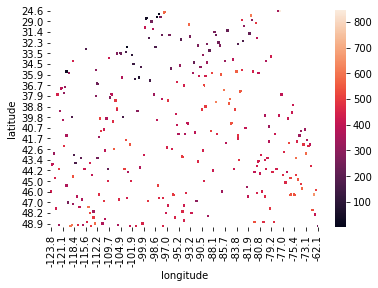

In [34]:
import seaborn as sns
wofost_mat = wofost_output.pivot('latitude', 'longitude', 'TWSO')
ax = sns.heatmap(wofost_mat)

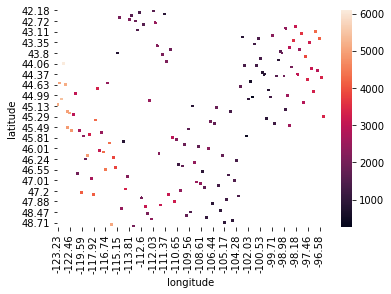

In [35]:
yield_mat = real_yield_data.pivot('latitude', 'longitude', 'Value')
ax = sns.heatmap(yield_mat)

In [36]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent='myGeocoder')

def get_county(coordinates):
    location = locator.reverse(coordinates)
    try:
        county = location.raw['address']['county']
    except Exception as e:
        print(f'coordinates: {coordinates}, err: {e}')
        county = ''
    return county

def get_state(coordinates):
    location = locator.reverse(coordinates)
    try:
        state = location.raw['address']['state']
    except Exception as e:
        print(f'coordinates: {coordinates}, err: {e}')
        state = ''
    return state
#coordinates = '53.480837, -2.244914' #(lat, lon)
#get_county(coordinates)

In [37]:
# wofost_output['coordinates'] = wofost_output['latitude'].astype(str) + ' ' + wofost_output['longitude'].astype(str) 
# wofost_output['county'] = wofost_output['coordinates'].apply(lambda x: get_county(x))
# wofost_output.to_csv('simulation_output/exp1/wheat_2006_county.csv')

In [38]:
# wofost_output = pd.read_csv('simulation_output/exp1/wheat_2006_county.csv')
# wofost_output['state'] = wofost_output['coordinates'].apply(lambda x: get_state(x))
# wofost_output.to_csv('simulation_output/exp1/wheat_2006_county.csv')

In [44]:
# wofost_output = pd.read_csv('simulation_output/exp1/wheat_2006_county.csv')
# wofost_output['county'] = wofost_output['county'].str.replace('County', '')
# wofost_output['county'] = wofost_output['county'].str.upper()
# # wofost_output = wofost_output.loc[(wofost_output['longitude'] > -124.848974) & (wofost_output['longitude'] < -66.885444) & (wofost_output['latitude'] > 24.396308) & (wofost_output['latitude'] < 49.384358)]
# wofost_output['state'] = utils.us_state_abbrev(wofost_output['state'])
# wofost_output.head()
# wofost_output.to_csv('simulation_output/exp1/wheat_2006_county_state.csv')

In [52]:
# merged = wofost_output.merge(real_yield_data, how='inner',
#                              left_on=['county'], right_on=['County'])
# merged.describe()

,Unnamed: 0,Unnamed: 0.1,DVS,LAIMAX,TAGP,TWSO,TWLV,TWST,TWRT,CTRAT,RD,DOS,DOV,latitude_x,longitude_x,Year,Value,latitude_y,longitude_y
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
from scipy.spatial import distance

def find_closest_soil(df1, df2):
    d = np.zeros(len(df1))
    for i in range(len(df1)):
        lat = df1.loc[i]['latitude']
        lon = df1.loc[i]['longitude']
        p1 = (lat, lon)
        temp = []
        for j in range(len(df2)):
            p2 = (df2.loc[j]['latitude'], df2.loc[j]['longitude'])
            temp.append(distance.euclidean(p1, p2))
        d[i] = np.argmin(temp)
    return d

In [65]:
# Mapping from real_yield_data to wofost_output, i.e. real_yield_data[i] --> wofost_output[d[i]]
d = find_closest_soil(real_yield_data, wofost_output)

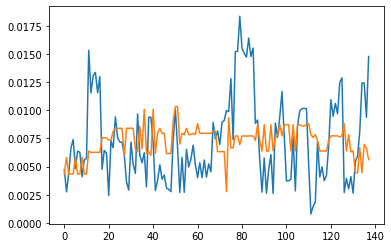

In [72]:
y, w = [], []
for i in range(len(real_yield_data)):
    y.append(real_yield_data.loc[i]['Value'])
    w.append(wofost_output.loc[d[i]]['TWSO'])

plt.figure()
plt.plot(y/np.sum(y))
plt.plot(w/np.sum(w))